The ground Hatree-Fock state is when 1up and 1down orbitals (molecular orbitals) are occupied. This is (1, 1, 0, 0) in fermion occupation basis. In Bravyi-Kitaev basis, this is (1, 0, 0, 0), so just X(0). 

In [11]:
from openfermion.ops import FermionOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.utils import hermitian_conjugated
from openfermion.utils import uccsd_generator
import numpy as np

from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from scipy.optimize import minimize
from pyquil import Program
from pyquil.gates import *

from openfermion.ops import QubitOperator
from forestopenfermion import pyquilpauli_to_qubitop, qubitop_to_pyquilpauli
from forestopenfermion import exponentiate

import numpy as np
import functools

from openfermion.hamiltonians import MolecularData, load_molecular_hamiltonian


In [12]:
sim = WavefunctionSimulator()
numQubit = 4
class Track:
    def __init__(self):
        self.cnt = 0


def solve_vqe_ucc_h2(hamiltonian: PauliSum, degree) -> float:
    # Construct a variational quantum eigensolver solution to find the lowest
    # eigenvalue of the given hamiltonian
    
    # degree 1: up to T_1
    # degree 2: up to T_2
    
    numParams = 0
    if degree == 1:
        numParams = 2
    elif degree == 2:
        numParams = 3
    params_init = np.random.rand(numParams)*0.5-0.25
    
    track = Track()

    def inc(t, xk):
        t.cnt += 1
    
    def ansatz_energy(t, params):
        t.cnt += 1
        p = None
        p = Program()
        
        # Reference state
        p += X(0)
        
        single_amp = []
        double_amp = []
        
        # occupied: 0,1 unoccupied: 2,3
        single_amp.append([[2,0], params[0]])
        single_amp.append([[3,1], params[1]])
        
        if degree >= 2:
            double_amp.append([[2,0,3,1], params[2]])
        
        ucc_gen = uccsd_generator(single_amp, double_amp)
        ucc_gen_qubitop = bravyi_kitaev(ucc_gen)
        try:
            ucc_program = exponentiate(ucc_gen_qubitop/(-1j))
        except:
            ucc_program = I(0)
        p += ucc_program

        energy = sim.expectation(p, hamiltonian).real
        return energy

    params_answer = minimize(functools.partial(ansatz_energy, track), params_init, method='L-BFGS-B').x
    print(params_answer)
    return ansatz_energy(track, params_answer), track.cnt

In [13]:
def get_ground_energy_ucc_h2(interaction_hamil, degree):
    fermionop_hamil = FermionOperator()
    for key in interaction_hamil:
        value = interaction_hamil[key]
        fermionop_hamil += FermionOperator(term=key, coefficient=value)
        
    qubitop_hamil = bravyi_kitaev(fermionop_hamil)
    pauliop_hamil = qubitop_to_pyquilpauli(qubitop_hamil)
    
    sim = WavefunctionSimulator()
    return solve_vqe_ucc_h2(pauliop_hamil, degree)


In [15]:
basis = 'sto-3g'
multiplicity = 1  # 2S+1
charge = 0

import matplotlib.pyplot as plt
%matplotlib inline

bond_lengths = np.linspace(0.3, 2.5, 23)
vqe_ground_energies_mean = []
vqe_ground_energies_std = []
vqe_iter_mean = []
vqe_iter_std = []

for degree in [1]:
    gelist = []
    gestdlist = []
    iterlist = []
    iterstdlist = []
    for bond_length in bond_lengths:
        geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
        description = str(round(bond_length, 2))
        h2_interaction_hamil = load_molecular_hamiltonian(geometry,
            basis,
            multiplicity,
            description,
            n_active_electrons=None,
            n_active_orbitals=None)

        gelist_temp = []
        iterlist_temp = []
        for i in range(1):
            ge, cnt = get_ground_energy_ucc_h2(h2_interaction_hamil, degree)
            print('bond length: ', round(bond_length, 2), ' ground state energy: ', ge, ' iteration: ', cnt)
            gelist_temp.append(ge)
            iterlist_temp.append(cnt)
        gelist.append(np.mean(gelist_temp))
        gestdlist.append(np.std(gelist_temp))
        iterlist.append(np.mean(iterlist_temp))
        iterstdlist.append(np.std(iterlist_temp))
        
    vqe_ground_energies_mean.append(gelist)
    vqe_ground_energies_std.append(gestdlist)
    vqe_iter_mean.append(np.mean(iterlist))
    vqe_iter_std.append(np.mean(iterstdlist))


[-1.32755138e-07 -4.86839565e-07]
bond length:  0.3  ground state energy:  -0.5938277645844932  iteration:  19
[-1.52994902e-08 -9.81272964e-08]
bond length:  0.4  ground state energy:  -0.9043613977138323  iteration:  19
[-1.32581252e-08 -1.05157223e-07]
bond length:  0.5  ground state energy:  -1.0429962765072087  iteration:  19
[-1.26999042e-06 -1.36214410e-06]
bond length:  0.6  ground state energy:  -1.1011282431322822  iteration:  19
[-1.56013549e-06  2.67764767e-08]
bond length:  0.7  ground state energy:  -1.1173490350683228  iteration:  19
[ 6.01778404e-06 -4.19493262e-06]
bond length:  0.8  ground state energy:  -1.1108503969665342  iteration:  19
[-2.86091309e-06  1.86313329e-06]
bond length:  0.9  ground state energy:  -1.0919140401041942  iteration:  25
[-1.32462217e-06  1.09256037e-06]
bond length:  1.0  ground state energy:  -1.0661086480813662  iteration:  28
[ 2.71010046e-06 -1.48082753e-06]
bond length:  1.1  ground state energy:  -1.0365388735385626  iteration:  31
[

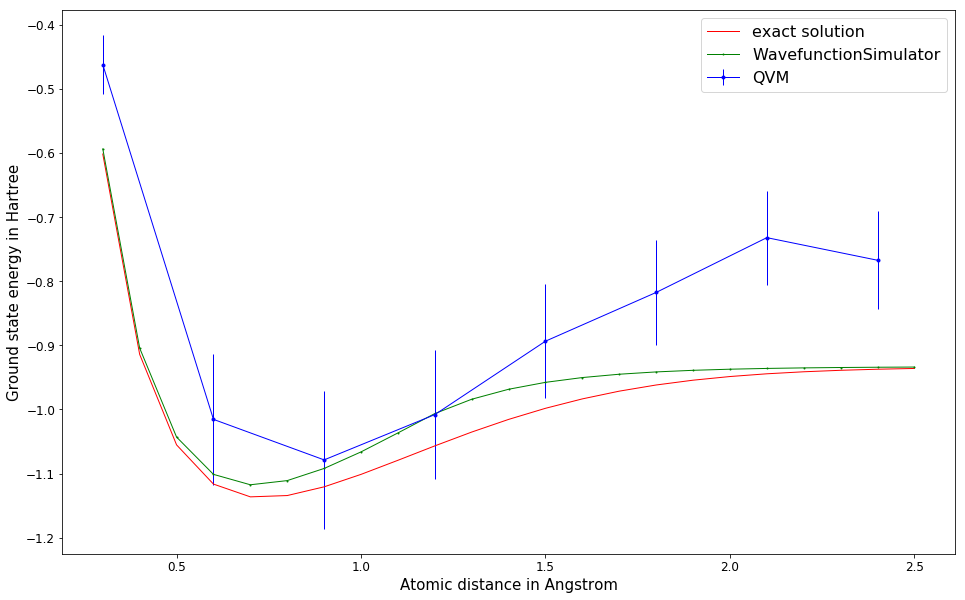

In [29]:
# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1

vqe_qvm_deg1 = np.array([-0.4624058470678082, -1.015415011064866, -1.078574021527077, -1.0080117573300524, -0.8935215369858669, -0.8175487109835171, -0.7321655888885132, -0.7673884787306767])
vqe_qvm_deg1_err = vqe_qvm_deg1*0.1

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for bond_length in np.linspace(0.3, 2.5, 23):
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
#    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    fci_energies += [molecule.fci_energy]

plt.figure(figsize=(16,10))
plt.plot(bond_lengths, fci_energies, 'r-', linewidth=1, markersize=1, label='exact solution')
plt.errorbar(np.linspace(0.3, 2.4, 8), vqe_qvm_deg1, vqe_qvm_deg1_err, color='b', marker='o', linewidth=1, markersize=3, label='QVM')
plt.plot(bond_lengths, vqe_ground_energies_mean[0], 'go-', linewidth=1, markersize=1, label='WavefunctionSimulator')
#plt.plot(bond_lengths, vqe_ground_energies_mean[1], 'bo-', linewidth=1, markersize=1, label='degree=2')
plt.tick_params(labelsize = 12)
plt.legend(prop={'size': 16})
plt.ylabel('Ground state energy in Hartree', size=15)
plt.xlabel('Atomic distance in Angstrom', size=15)
plt.savefig('PLOT7.pdf', bbox_inches='tight', size=15)
plt.show()



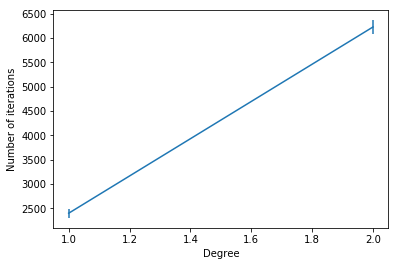

[34.313043478260866, 43.85217391304349]
[1.37581119 0.97010635]
[2401.91304348 6227.00869565]
[ 96.30678334 137.75510214]


In [17]:
numGates = np.array([34+36, 106+36])
#plt.plot([1,2], np.array(vqe_iter_mean)*numGates, 'o-')
plt.errorbar([1,2], np.array(vqe_iter_mean)*numGates, np.array(vqe_iter_std)*numGates/np.sqrt(23))
plt.ylabel('Number of iterations')
plt.xlabel('Degree')
plt.show()
print(vqe_iter_mean)
print(vqe_iter_std/np.sqrt(23))

print(np.array(vqe_iter_mean)*numGates)
print(np.array(vqe_iter_std)*numGates/np.sqrt(23))

In [ ]:
print(max(max(vqe_ground_energies_std)))

[0.9776784174213188, 0.9999999999566576]


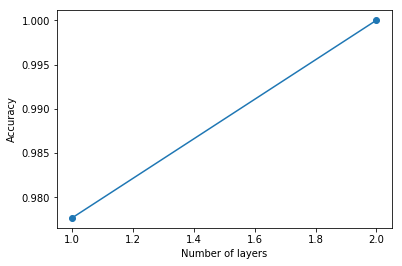

In [18]:
accuracy = []
for i in range(2):
    acc = 1-np.mean(np.array(vqe_ground_energies_mean[i])-np.array(fci_energies))
    accuracy.append(acc)
print(accuracy)
plt.plot([1,2], accuracy, 'o-')
plt.ylabel('Accuracy')
plt.xlabel('Number of layers')
plt.show()